In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
df = pd.read_csv('../data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [3]:
df['kWh'] = df['Area_km2'] / df['Area / Electricity']
df = df.drop(['Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)

In [4]:
df.columns

Index(['CO2 (mg C m¯² d¯¹)', 'CH4 (mg C m-2 d-1)', 'Area_km2', 'Age',
       'Volume_km3', 'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_spring_avg_lc', 'temp_summer_avg_lc', 'temp_fall_avg_lc',
       'temp_winter_avg_lc', 'NDVI_annual_avg', 'NDVI_spring_avg_lc',
       'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc', 'NDVI_winter_avg_lc',
       'npp_annual_avg', 'npp_spring_avg_lc', 'npp_summer_avg_lc',
       'npp_fall_avg_lc', 'npp_winter_avg_lc', 'erosion', 'precip', 'kWh'],
      dtype='object')

In [5]:
df.shape

(154, 25)

In [ ]:
#create co2 df

In [7]:
ch4 = df.drop(['CO2 (mg C m¯² d¯¹)'], axis=1)
ch4 = ch4[ch4['CH4 (mg C m-2 d-1)'].notna()]

## XGBoost

In [8]:
X = ch4.drop('CH4 (mg C m-2 d-1)', axis=1)
Y = ch4['CH4 (mg C m-2 d-1)']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [9]:
import xgboost

In [12]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
print('train r2:', xgb_reg.score(x_train, y_train))
print('test r2 :', xgb_reg.score(x_test, y_test))

train r2: 0.9989797154779955
test r2 : 0.06527082545632534


In [16]:
xgb_reg.fit(x_train, y_train,
           eval_set=[(x_val, y_val)], early_stopping_rounds=5)

[0]	validation_0-rmse:51.42019
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:48.23997
[2]	validation_0-rmse:46.81720
[3]	validation_0-rmse:46.19386
[4]	validation_0-rmse:46.45286
[5]	validation_0-rmse:46.39922
[6]	validation_0-rmse:46.08897
[7]	validation_0-rmse:46.01775
[8]	validation_0-rmse:46.19954
[9]	validation_0-rmse:46.40628
[10]	validation_0-rmse:46.29667
[11]	validation_0-rmse:46.43022
[12]	validation_0-rmse:46.49732
Stopping. Best iteration:
[7]	validation_0-rmse:46.01775



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
print('train r2:', xgb_reg.score(x_train, y_train))
print('test r2 :', xgb_reg.score(x_test, y_test))

train r2: 0.9402094771933329
test r2 : 0.05543273664780901


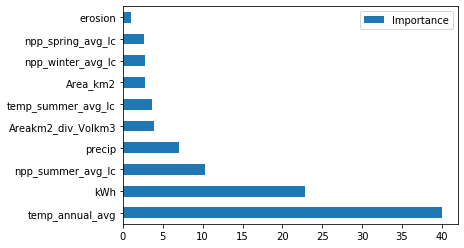

In [18]:
# list(zip(x_train.columns, xgb_reg.feature_importances_))
pd.DataFrame(index=x_train.columns, data=xgb_reg.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')



#### comparing predictions to actual values
- are there patterns we can see where residuals are low or high?

In [19]:
predictions = pd.DataFrame(columns=['actual','predicted'], data=list(zip(y_test, xgb_reg.predict(x_test))))

In [20]:
comparing = x_test.copy().reset_index().drop(['index'], axis=1)
comparing['actual'] = predictions['actual']
comparing['predicted'] = predictions['predicted']

### scaling values

In [22]:
from sklearn.preprocessing import StandardScaler

data = ch4.copy()
scaler = StandardScaler()
ch4_scaled = pd.DataFrame(scaler.fit_transform(data),columns=ch4.columns)

In [35]:
X = ch4_scaled.drop('CH4 (mg C m-2 d-1)', axis=1)
Y = ch4_scaled['CH4 (mg C m-2 d-1)']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [36]:
xgb_reg2 = xgboost.XGBRegressor()
xgb_reg2.fit(x_train, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

[0]	validation_0-rmse:0.55739
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.39594
[3]	validation_0-rmse:0.36356
[4]	validation_0-rmse:0.34726
[5]	validation_0-rmse:0.34261
[6]	validation_0-rmse:0.34042
[7]	validation_0-rmse:0.33807
[8]	validation_0-rmse:0.33642
[9]	validation_0-rmse:0.33650
[10]	validation_0-rmse:0.33579
[11]	validation_0-rmse:0.33575
[12]	validation_0-rmse:0.33527
[13]	validation_0-rmse:0.33627
[14]	validation_0-rmse:0.33723
[15]	validation_0-rmse:0.33664
[16]	validation_0-rmse:0.33631
[17]	validation_0-rmse:0.33582
Stopping. Best iteration:
[12]	validation_0-rmse:0.33527



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [37]:
print('train r2:', xgb_reg2.score(x_train, y_train))
print('test  r2:', xgb_reg2.score(x_test, y_test))

train r2: 0.9915714687744884
test  r2: 0.07318319281858199


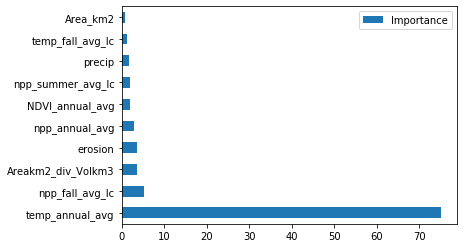

In [38]:
pd.DataFrame(index=x_train.columns, data=xgb_reg2.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')

## grid search

In [39]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(0,100,10),
    "learning_rate" : np.linspace(.001,.1,10),
    "max_depth" : range(1,11)
}

grid_search_xgb = GridSearchCV(xgb_reg2, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_xgb.fit(x_train, y_train)

CPU times: user 6.2 s, sys: 156 ms, total: 6.36 s
Wall time: 23.4 s


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs...
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': array([0.001, 0.012, 0.023, 0.034, 0.045,

In [40]:
grid_search_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 20}

In [41]:
grid_search_xgb.best_score_

-0.06920052569953239

In [43]:
xgb_best = xgboost.XGBRegressor(learning_rate=.1, n_estimators=20, max_depth=1)
xgb_best.fit(x_train, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=10)

print('')
print('train r2:', xgb_best.score(x_train, y_train))
print('test  r2:', xgb_best.score(x_test, y_test))

[0]	validation_0-rmse:0.68037
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.63146
[2]	validation_0-rmse:0.58861
[3]	validation_0-rmse:0.55122
[4]	validation_0-rmse:0.51875
[5]	validation_0-rmse:0.48919
[6]	validation_0-rmse:0.46259
[7]	validation_0-rmse:0.44163
[8]	validation_0-rmse:0.42428
[9]	validation_0-rmse:0.40738
[10]	validation_0-rmse:0.39290
[11]	validation_0-rmse:0.38193
[12]	validation_0-rmse:0.37088
[13]	validation_0-rmse:0.36374
[14]	validation_0-rmse:0.35642
[15]	validation_0-rmse:0.35105
[16]	validation_0-rmse:0.34546
[17]	validation_0-rmse:0.34114
[18]	validation_0-rmse:0.33825
[19]	validation_0-rmse:0.33531

train r2: 0.4796927924946782
test  r2: 0.04121759115426349


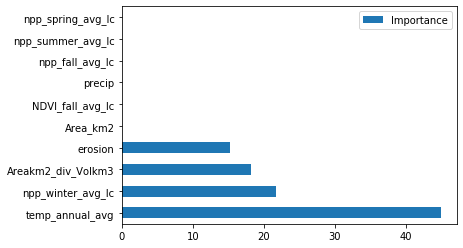

In [44]:
pd.DataFrame(index=x_train.columns, data=xgb_best.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')


In [45]:
predictions = pd.DataFrame(columns=['actual','predicted'], data=list(zip(y_test, xgb_reg.predict(x_test))))

comparing = x_test.copy().reset_index().drop(['index'], axis=1)
comparing['actual'] = predictions['actual']
comparing['predicted'] = predictions['predicted']
comparing['error'] = abs(comparing['actual'] - comparing['predicted'])/comparing['actual']

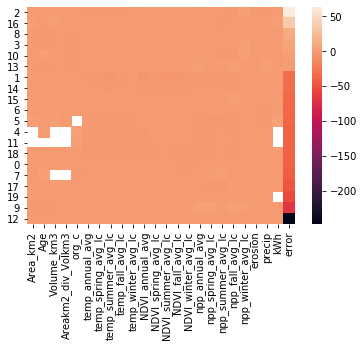

In [46]:
import seaborn as sns

pd.options.display.max_rows = None
pd.options.display.max_columns = None

sns.heatmap(comparing.sort_values(by='error', ascending=False).drop(['actual','predicted'],axis=1))

In [ ]:
##try with imputing NaNs in the train set:

In [47]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)

x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)

#check
for column in x_train:
    print(column, ':',  x_train_imputed[column].isna().sum())

Area_km2 : 0
Age : 0
Volume_km3 : 0
Areakm2_div_Volkm3 : 0
org_c : 0
temp_annual_avg : 0
temp_spring_avg_lc : 0
temp_summer_avg_lc : 0
temp_fall_avg_lc : 0
temp_winter_avg_lc : 0
NDVI_annual_avg : 0
NDVI_spring_avg_lc : 0
NDVI_summer_avg_lc : 0
NDVI_fall_avg_lc : 0
NDVI_winter_avg_lc : 0
npp_annual_avg : 0
npp_spring_avg_lc : 0
npp_summer_avg_lc : 0
npp_fall_avg_lc : 0
npp_winter_avg_lc : 0
erosion : 0
precip : 0
kWh : 0


In [48]:
xgb_reg_imputed = xgboost.XGBRegressor()
xgb_reg_imputed.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

[0]	validation_0-rmse:0.55739
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.39594
[3]	validation_0-rmse:0.36356
[4]	validation_0-rmse:0.35774
[5]	validation_0-rmse:0.36234
[6]	validation_0-rmse:0.36784
[7]	validation_0-rmse:0.37191
[8]	validation_0-rmse:0.38006
[9]	validation_0-rmse:0.38715
Stopping. Best iteration:
[4]	validation_0-rmse:0.35774



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [49]:
print('train r2:', xgb_reg_imputed.score(x_train_imputed, y_train))
print('test  r2:', xgb_reg_imputed.score(x_test, y_test))

train r2: 0.8187928522068569
test  r2: 0.08334489426814307


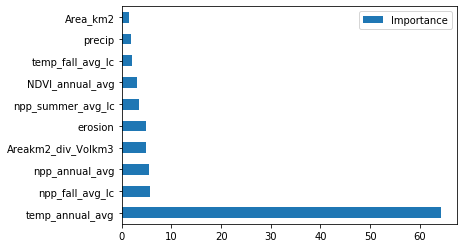

In [50]:
pd.DataFrame(index=x_train.columns, data=xgb_reg_imputed.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')


In [51]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(0,100,10),
    "learning_rate" : np.linspace(.001,.5,10),
    "max_depth" : range(1,11)
}

grid_search_xgb_imputed = GridSearchCV(xgb_reg_imputed, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_xgb_imputed.fit(x_train_imputed, y_train)

CPU times: user 4.4 s, sys: 196 ms, total: 4.6 s
Wall time: 22.5 s


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs...
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 

In [52]:
grid_search_xgb_imputed.best_params_

{'learning_rate': 0.22277777777777777, 'max_depth': 1, 'n_estimators': 10}

In [53]:
grid_search_xgb_imputed.best_score_

-0.05538615819691989

In [54]:
xgb_best2 = xgboost.XGBRegressor(learning_rate=.22277, n_estimators=10, max_depth=1)
xgb_best2.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=10)

print('')
print('train r2:', xgb_best2.score(x_train_imputed, y_train))
print('test  r2:', xgb_best2.score(x_test, y_test))

[0]	validation_0-rmse:0.61416
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.52564
[2]	validation_0-rmse:0.45988
[3]	validation_0-rmse:0.44353
[4]	validation_0-rmse:0.41103
[5]	validation_0-rmse:0.41143
[6]	validation_0-rmse:0.39544
[7]	validation_0-rmse:0.38166
[8]	validation_0-rmse:0.39177
[9]	validation_0-rmse:0.38526

train r2: 0.4641552990192635
test  r2: 0.034367446685165226


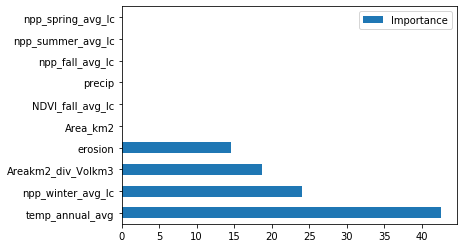

In [55]:
pd.DataFrame(index=x_train.columns, data=xgb_best2.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')

In [ ]:
## try cutting down the number of features - maybe theres too much noise:

In [56]:
X.columns

Index(['Area_km2', 'Age', 'Volume_km3', 'Areakm2_div_Volkm3', 'org_c',
       'temp_annual_avg', 'temp_spring_avg_lc', 'temp_summer_avg_lc',
       'temp_fall_avg_lc', 'temp_winter_avg_lc', 'NDVI_annual_avg',
       'NDVI_spring_avg_lc', 'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc',
       'NDVI_winter_avg_lc', 'npp_annual_avg', 'npp_spring_avg_lc',
       'npp_summer_avg_lc', 'npp_fall_avg_lc', 'npp_winter_avg_lc', 'erosion',
       'precip', 'kWh'],
      dtype='object')

In [57]:
X_reduced = X[['Area_km2', 'Age', 'Volume_km3', 'Areakm2_div_Volkm3', 'org_c',
       'temp_summer_avg_lc', 'temp_winter_avg_lc', 'NDVI_annual_avg', 'npp_annual_avg',
       'erosion', 'precip', 'kWh']]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [59]:
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)
x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)


xgb_reg_imputed2 = xgboost.XGBRegressor()
xgb_reg_imputed2.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

print('')
print('train r2:', xgb_reg_imputed2.score(x_train, y_train))
print('test  r2:', xgb_reg_imputed2.score(x_test, y_test))

[0]	validation_0-rmse:0.57512
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.47790
[2]	validation_0-rmse:0.41955
[3]	validation_0-rmse:0.39035
[4]	validation_0-rmse:0.38549
[5]	validation_0-rmse:0.38515
[6]	validation_0-rmse:0.39172
[7]	validation_0-rmse:0.39754
[8]	validation_0-rmse:0.40862
[9]	validation_0-rmse:0.41266
[10]	validation_0-rmse:0.41763
Stopping. Best iteration:
[5]	validation_0-rmse:0.38515


train r2: 0.8840661261420903
test  r2: 0.0830955643807828


In [ ]:
### try again with train-test-split into thirds

In [60]:
from sklearn.preprocessing import StandardScaler

data = ch4.copy()
scaler = StandardScaler()
ch4_scaled = pd.DataFrame(scaler.fit_transform(data),columns=ch4.columns)

In [61]:
X = ch4_scaled.drop('CH4 (mg C m-2 d-1)', axis=1)
Y = ch4_scaled['CH4 (mg C m-2 d-1)']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

In [62]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)

x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)

[0]	validation_0-rmse:0.59107
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.46204
[2]	validation_0-rmse:0.38802
[3]	validation_0-rmse:0.33642
[4]	validation_0-rmse:0.30723
[5]	validation_0-rmse:0.28823
[6]	validation_0-rmse:0.27623
[7]	validation_0-rmse:0.26886
[8]	validation_0-rmse:0.26634
[9]	validation_0-rmse:0.26530
[10]	validation_0-rmse:0.26411
[11]	validation_0-rmse:0.26333
[12]	validation_0-rmse:0.26278
[13]	validation_0-rmse:0.26277
[14]	validation_0-rmse:0.26325
[15]	validation_0-rmse:0.26355
[16]	validation_0-rmse:0.26403
[17]	validation_0-rmse:0.26463
[18]	validation_0-rmse:0.26509
Stopping. Best iteration:
[13]	validation_0-rmse:0.26277

train r2: 0.9902990021503498
test  r2: 0.08415824328191035


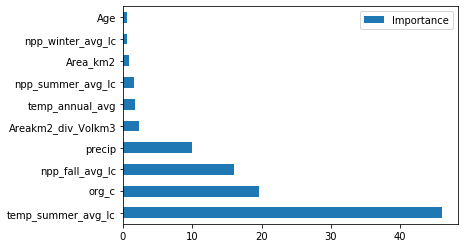

In [63]:
xgb_reg_thirds = xgboost.XGBRegressor()
xgb_reg_thirds.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

print('train r2:', xgb_reg_thirds.score(x_train_imputed, y_train))
print('test  r2:', xgb_reg_thirds.score(x_test, y_test))

pd.DataFrame(index=x_train.columns, data=xgb_reg_thirds.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')


In [65]:
xgb_reg_thirds.set_params(learning_rate=.22277, n_estimators=10, max_depth=1)

xgb_reg_thirds.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

print('train r2:', xgb_reg_thirds.score(x_train_imputed, y_train))
print('test  r2:', xgb_reg_thirds.score(x_test, y_test))

[0]	validation_0-rmse:0.64815
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.53034
[2]	validation_0-rmse:0.44712
[3]	validation_0-rmse:0.38810
[4]	validation_0-rmse:0.33299
[5]	validation_0-rmse:0.30242
[6]	validation_0-rmse:0.27065
[7]	validation_0-rmse:0.24165
[8]	validation_0-rmse:0.23307
[9]	validation_0-rmse:0.22616
train r2: 0.6031870231171468
test  r2: 0.02337468453789282


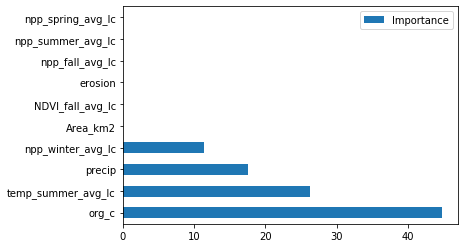

In [66]:
pd.DataFrame(index=x_train.columns, data=xgb_reg_thirds.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')


In [ ]:
## squared, unscaled target
## imputed, scaled features

In [67]:
X = ch4_scaled.drop('CH4 (mg C m-2 d-1)', axis=1)
Y = ch4['CH4 (mg C m-2 d-1)']

In [68]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

In [69]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)

x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)

In [70]:
y_train_sq = y_train**2
y_val_sq = y_val**2
y_test_sq = y_test**2

In [71]:
xgb_reg_sq = xgboost.XGBRegressor(learning_rate=.8, n_estimators=100, max_depth=10)
# xgb_reg_sq.set_params(learning_rate=.33367, n_estimators=100, max_depth=2)

xgb_reg_sq.fit(x_train_imputed, y_train_sq, 
             eval_set=[(x_val, y_val_sq)], 
             early_stopping_rounds=10)

print('train r2:', xgb_reg_sq.score(x_train_imputed, y_train_sq))
print('test  r2:', xgb_reg_sq.score(x_test, y_test_sq))

[0]	validation_0-rmse:3743.61450
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:4002.13989
[2]	validation_0-rmse:4468.88330
[3]	validation_0-rmse:4765.54248
[4]	validation_0-rmse:4951.22998
[5]	validation_0-rmse:5062.75879
[6]	validation_0-rmse:5128.33838
[7]	validation_0-rmse:5168.43750
[8]	validation_0-rmse:5191.43066
[9]	validation_0-rmse:5205.28564
[10]	validation_0-rmse:5214.14648
Stopping. Best iteration:
[0]	validation_0-rmse:3743.61450

train r2: 0.5856259264057337
test  r2: -0.052567466515917705


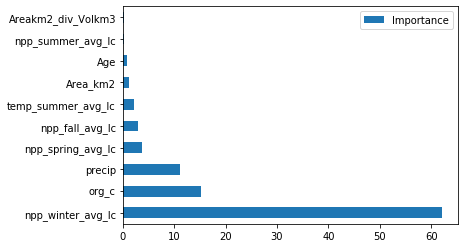

In [72]:
pd.DataFrame(index=x_train.columns, data=xgb_reg_sq.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')
